# Managerial insights

In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

In [2]:
# For final compilation
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "Computer Modern Serif"

## Helpers

In [3]:
def load(files: list[str]) -> pd.DataFrame:
    data = []
    for file in files:
        with open(file, "r") as fh:
            data.append(json.load(fh))
    
    df = pd.DataFrame(data)
    df["avg_route_duration"] = pd.to_timedelta(df["avg_route_duration"])
    df["experiment"] = range(1, len(files) + 1)

    num_routes_day = df["avg_num_routes_per_day"]
    df["avg_distance"] = df["avg_route_distance"] * num_routes_day
    df["avg_clusters"] = df["avg_route_clusters"] * num_routes_day
    df["avg_stops"] = df["avg_route_stops"] * num_routes_day

    return df

In [4]:
def report(df: pd.DataFrame):
    duration = df.avg_route_duration.mean() / np.timedelta64(1, "h")
    print(f"Avg distance      : {df.avg_distance.mean() / 1_000:.1f} km")
    print(f"Avg duration      : {duration:.1f} hours")
    print(f"Avg service level : {100 * df.avg_service_level.mean():.1f}%")
    print(f"Avg excess volume : {df.avg_excess_volume.mean():.1f} litres")
    print(f"Avg clusters      : {df.avg_clusters.mean():.1f}")
    print(f"Avg #routes       : {df.avg_num_routes_per_day.mean():.1f}")
    print(f"Max #unserved     : {df.num_unserved_containers.max()}")
    print(f"Avg fill rate     : {100 * df.avg_fill_factor.mean():.1f}%")

## Tuning

Tuning $\rho$ and $\epsilon$.

In [5]:
tune = load([f"out/tuning/prize_{idx}.json" for idx in range(1, 122)])
tune["rho"] = np.repeat(1000 * 2 ** np.arange(11), 11)
tune["epsilon"] = 1 - np.tile(np.linspace(0.9, 1.0, num=11), 11)

In [6]:
tune.pivot(index="epsilon", columns="rho", values="avg_distance")

rho,1000,2000,4000,8000,16000,32000,64000,128000,256000,512000,1024000
epsilon,,,,,,,,,,,
0.00,78621.517711,98523.907357,109755.130790,120897.953678,129501.926431,134560.177112,138481.825613,139527.822888,141401.713896,143751.901907,145190.182561
0.01,111402.092643,115535.356948,120264.752044,124241.084469,129467.168937,134401.580381,139214.247956,143108.435967,142000.163488,143529.068120,145221.324251
0.02,112604.752044,116311.675749,119922.057221,124806.991826,130260.188011,134157.920981,138840.073569,140010.997275,141478.970027,144091.705722,146006.297003
0.03,113584.348774,117473.686649,120791.373297,124635.989101,129268.468665,134368.310627,137974.509537,140049.321526,141788.566757,143744.416894,145865.667575
0.04,114524.877384,117657.182561,120505.555858,124233.918256,130287.828338,133654.861035,138937.299728,139740.645777,141728.035422,143812.337875,145643.708447
0.05,114405.335150,117878.506812,120564.893733,124527.727520,130099.204360,133806.446866,137750.419619,140089.490463,141981.359673,143220.242507,146184.177112
0.06,115195.376022,118274.493188,121451.599455,126615.425068,130403.269755,134487.065395,137160.972752,139253.318801,141989.643052,143710.495913,145186.863760
0.07,115909.343324,118682.850136,122118.365123,125103.940054,129894.689373,134267.547684,137105.773842,139835.861035,142314.844687,143865.400545,145444.514986
0.08,115545.482289,118804.138965,122022.610354,125865.160763,130696.149864,133869.190736,137390.741144,141050.705722,141334.514986,143644.313351,145111.280654


In [7]:
tune.pivot(index="epsilon", columns="rho", values="avg_service_level")

rho,1000,2000,4000,8000,16000,32000,64000,128000,256000,512000,1024000
epsilon,,,,,,,,,,,
0.00,0.767297,0.905089,0.949112,0.971550,0.983066,0.989711,0.993198,0.995414,0.996899,0.997593,0.998701
0.01,0.798426,0.902262,0.948045,0.970571,0.982931,0.990205,0.992929,0.995593,0.997517,0.997754,0.998487
0.02,0.802288,0.904945,0.949843,0.970249,0.984270,0.989800,0.993727,0.995509,0.996356,0.998279,0.998754
0.03,0.806891,0.904681,0.948437,0.970501,0.983632,0.989615,0.993419,0.995833,0.997062,0.997665,0.998472
0.04,0.808433,0.905280,0.950183,0.971178,0.982834,0.990294,0.993432,0.995375,0.997554,0.997826,0.998561
0.05,0.816850,0.904040,0.950918,0.970730,0.982806,0.989279,0.993134,0.996114,0.997040,0.997663,0.998574
0.06,0.812650,0.908051,0.949724,0.970049,0.983528,0.989179,0.993321,0.995190,0.996876,0.998010,0.998684
0.07,0.813343,0.908833,0.951717,0.971307,0.982239,0.989078,0.993928,0.996084,0.997479,0.997916,0.998648
0.08,0.817795,0.909613,0.949297,0.972040,0.983336,0.989724,0.994035,0.995362,0.997078,0.997773,0.998524


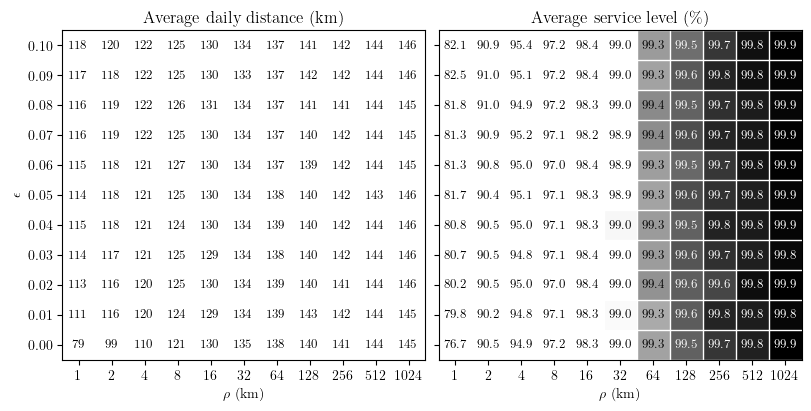

In [8]:
avg_distance = tune.pivot(
    index="epsilon",
    columns="rho",
    values="avg_distance",
).to_numpy()

avg_service_level = tune.pivot(
    index="epsilon",
    columns="rho",
    values="avg_service_level",
).to_numpy()

rhos = sorted(tune.rho.unique() // 1_000)
epsilons = sorted(tune.epsilon.unique())

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharey=True,
    layout="constrained",
)


def make_plot(ax, data, **kwargs):
    ax.imshow(data, origin="lower", aspect="auto", **kwargs)

    ax.set_xticks(np.arange(len(rhos)), labels=rhos)
    ax.set_yticks(np.arange(len(epsilons)), labels=map("{:.2f}".format, epsilons))

    ax.set_xticks(np.arange(len(rhos)) - .5, minor=True)
    ax.set_yticks(np.arange(len(epsilons) + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)


make_plot(ax1, avg_distance, vmin=0, vmax=100, cmap="gray")
make_plot(ax2, avg_service_level, vmin=0.99, cmap="gray_r")

for i in range(len(epsilons)):
    for j in range(len(rhos)):
        ax1.text(
            j,
            i,
            "{:.0f}".format(avg_distance[i, j] / 1_000),
            ha="center",
            va="center", 
            c="black",
            size=9,
        )

        ax2.text(
            j,
            i,
            "{:.1f}".format(100 * avg_service_level[i, j]),
            ha="center",
            va="center",
            c="white" if avg_service_level[i, j] >= 0.9945 else "black",
            size=9,
        )

ax1.set_ylabel("$\epsilon$")
ax1.set_xlabel("$\\rho$ (km)")
ax2.set_xlabel("$\\rho$ (km)")

ax1.set_title("Average daily distance (km)")
ax2.set_title("Average service level (\%)")

plt.savefig("out/case_tuning.pdf", transparent=True)

## Results

Results on various different instance sets.

In [9]:
baseline3 = load([f"out/3vehicles/baseline3_{idx}.json" for idx in range(1, 51)])
baseline3["containers"] = np.repeat([150, 175, 200, 225, 250], 10)

baseline4 = load([f"out/results/baseline4_{idx}.json" for idx in range(1, 51)])
baseline4["containers"] = np.repeat([150, 175, 200, 225, 250], 10)

base4perfect = load([f"out/perfect/baseline4perfect_{idx}.json" for idx in range(1, 51)])
base4perfect["containers"] = np.repeat([150, 175, 200, 225, 250], 10)

In [10]:
prize3 = load([f"out/3vehicles/prize3_{idx}.json" for idx in range(1, 51)])
prize3["rho"] = np.repeat(np.array([4, 16, 64, 256, 1024]) * 1_000, 10)

prize4 = load([f"out/results/prize4_{idx}.json" for idx in range(1, 51)])
prize4["rho"] = np.repeat(np.array([4, 16, 64, 256, 1024]) * 1_000, 10)

prize4perfect = load([f"out/perfect/prize4perfect_{idx}.json" for idx in range(1, 51)])
prize4perfect["rho"] = np.repeat(np.array([4, 16, 64, 256, 1024]) * 1_000, 10)

In [11]:
report(baseline3[baseline3.containers == 200])

Avg distance      : 215.7 km
Avg duration      : 7.5 hours
Avg service level : 99.5%
Avg excess volume : 1101.3 litres
Avg clusters      : 200.0
Avg #routes       : 3.0
Max #unserved     : 5
Avg fill rate     : 61.2%


In [12]:
report(baseline4[baseline4.containers == 250])  # default baseline

Avg distance      : 251.2 km
Avg duration      : 6.8 hours
Avg service level : 99.9%
Avg excess volume : 1536.6 litres
Avg clusters      : 250.0
Avg #routes       : 4.0
Max #unserved     : 5
Avg fill rate     : 48.9%


In [13]:
report(base4perfect[base4perfect.containers == 250])  # default baseline w/ perfect information

Avg distance      : 245.3 km
Avg duration      : 6.8 hours
Avg service level : 99.7%
Avg excess volume : 1614.7 litres
Avg clusters      : 250.0
Avg #routes       : 4.0
Max #unserved     : 5
Avg fill rate     : 48.9%


In [14]:
report(prize3[prize3.rho == 1_024_000])  # prize-collecting, 3 vehicles

Avg distance      : 155.8 km
Avg duration      : 5.5 hours
Avg service level : 99.7%
Avg excess volume : 104.2 litres
Avg clusters      : 151.8
Avg #routes       : 3.0
Max #unserved     : 4
Avg fill rate     : 80.6%


In [15]:
report(prize4[prize4.rho == 1_024_000])  # regular prize-collecting, 4 vehicles

Avg distance      : 146.4 km
Avg duration      : 3.8 hours
Avg service level : 99.9%
Avg excess volume : 92.9 litres
Avg clusters      : 153.1
Avg #routes       : 4.0
Max #unserved     : 4
Avg fill rate     : 79.9%


In [16]:
report(prize4perfect[prize4perfect.rho == 1_024_000])  # w/ perfect information

Avg distance      : 143.6 km
Avg duration      : 3.8 hours
Avg service level : 99.9%
Avg excess volume : 80.8 litres
Avg clusters      : 150.4
Avg #routes       : 4.0
Max #unserved     : 4
Avg fill rate     : 81.3%


### Average distance vs. service level

The figure below compares average distance traveled per day (the total distance of all routes on a day) against the average service level that's achieved by a strategy.
Typically, as the distance increases, the service level should go up: more containers are visited, etc.
The key is to balance the two.

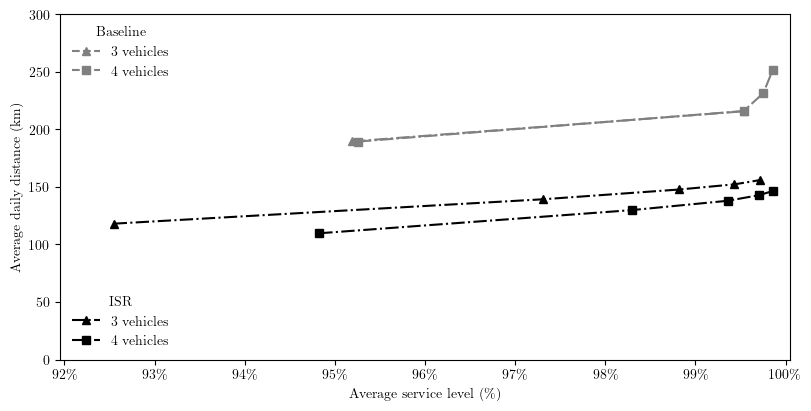

In [17]:
_, ax = plt.subplots(figsize=(8, 4), layout="constrained")

for idx, (data, marker) in enumerate(zip([baseline3, baseline4], ["^", "s"])):
    data = data[data.num_unserved_containers <= 5]
    ax.plot(
        data.avg_service_level.groupby(data.containers).mean(),
        data.avg_distance.groupby(data.containers).mean(),
        marker=marker,
        linestyle="-.",
        c="grey",
    )

for idx, (data, marker) in enumerate(zip([prize3, prize4], ["^", "s"])):
    ax.plot(
        data.avg_service_level.groupby(data.rho).mean(),
        data.avg_distance.groupby(data.rho).mean(),
        marker=marker,
        linestyle="-.",
        c="black",
    )

ticks = mtick.FuncFormatter(lambda x, _: "{0:g}".format(x / 1_000))
ax.yaxis.set_major_formatter(ticks)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_xlim([0.92 - 0.0005, 1 + 0.0005])
ax.set_ylim([0, 300_000])

legend1 = plt.legend(
    [
        Line2D([0], [0], color="grey", marker="^", linestyle="--"),
        Line2D([0], [0], color="grey", marker="s", linestyle="--"),
    ],
    ["3 vehicles", "4 vehicles"],
    frameon=False,
    title="Baseline",
    loc="upper left",
)

legend2 = plt.legend(
    [
        Line2D([0], [0], color="black", marker="^", linestyle="-."),
        Line2D([0], [0], color="black", marker="s", linestyle="-."),
    ],
    ["3 vehicles", "4 vehicles"],
    frameon=False,
    title="ISR",
    loc="lower left",
)

plt.gca().add_artist(legend1)

ax.set_xlabel("Average service level (\%)")
ax.set_ylabel("Average daily distance (km)")

plt.savefig("out/baseline_vs_prize.pdf", transparent=True)

### Summary table

Summary table of relevant performance measures, for the baseline and prize-collecting policies under different parametrisations.

In [18]:
def data2tuple(data):
    return (
        data.avg_distance.mean() / 1_000,  # km
        data.avg_route_duration.mean() / np.timedelta64(1, "h"),  # hours
        data.avg_num_routes_per_day.mean(),
        data.avg_clusters.mean(),
        (100 * data.avg_service_level).mean(),
        (100 * data.avg_fill_factor).mean(),
        data.avg_excess_volume.mean(),
        np.maximum(data.num_unserved_containers - 5, 0).mean(),
    )

rows = []
for base in [baseline3, baseline4]:
    for containers in [150, 175, 200, 225, 250]:
        rows.append(data2tuple(base[base.containers == containers]))
    
for prize in [prize3, prize4]:
    for rho in [4_000, 16_000, 64_000, 256_000, 1_024_000]:
        rows.append(data2tuple(prize[prize.rho == rho]))

df = pd.DataFrame(
    rows,
    columns=[
        "avg_dist",
        "avg_dur",
        "avg_num_routes",
        "avg_num_clusters",
        "avg_service_level",
        "avg_fill_factor",
        "avg_excess_volume",
        "num_unserved",
    ]
)

In [19]:
print(
    df.style.format(precision=1)
    .format("{:.1f} km", subset=["avg_dist"])
    .format("{:.1f} h", subset=["avg_dur"])
    .format(
        "{:.1f}\\%".format, 
        subset=["avg_service_level", "avg_fill_factor"],
    )
    .format(precision=0, subset=["avg_excess_volume", "num_unserved"])
    .to_latex()
)

\begin{tabular}{lrrrrrrrr}
 & avg_dist & avg_dur & avg_num_routes & avg_num_clusters & avg_service_level & avg_fill_factor & avg_excess_volume & num_unserved \\
0 & 171.7 km & 5.6 h & 3.0 & 150.0 & 97.1\% & 68.1\% & 2464 & 157 \\
1 & 189.4 km & 6.5 h & 3.0 & 175.0 & 95.2\% & 69.9\% & 2797 & 0 \\
2 & 215.7 km & 7.5 h & 3.0 & 200.0 & 99.5\% & 61.2\% & 1101 & 0 \\
3 & 0.0 km & 0.0 h & 0.0 & 0.0 & 100.0\% & 0.0\% & 0 & 845 \\
4 & 0.0 km & 0.0 h & 0.0 & 0.0 & 100.0\% & 0.0\% & 0 & 845 \\
5 & 171.8 km & 5.6 h & 3.0 & 150.0 & 97.0\% & 68.1\% & 2492 & 156 \\
6 & 189.3 km & 6.5 h & 3.0 & 175.0 & 95.3\% & 69.9\% & 2845 & 0 \\
7 & 215.9 km & 7.5 h & 3.0 & 200.0 & 99.5\% & 61.2\% & 1077 & 0 \\
8 & 231.4 km & 6.1 h & 4.0 & 225.0 & 99.8\% & 54.4\% & 1210 & 0 \\
9 & 251.2 km & 6.8 h & 4.0 & 250.0 & 99.9\% & 48.9\% & 1537 & 0 \\
10 & 118.0 km & 4.6 h & 3.0 & 137.3 & 92.5\% & 88.8\% & 357 & 3 \\
11 & 139.2 km & 5.1 h & 3.0 & 142.5 & 97.3\% & 85.9\% & 143 & 0 \\
12 & 147.7 km & 5.3 h & 3.0 & 145.8 & 98.